In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 16, 8)
latt_size = (16, 16, 8, 8)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (16, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
# dtype = torch.complex32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-9

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1672823749344572e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(lat_size=latt_size,dtype=dtype,device=device, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

Building grid list:
  Level 0: 16x16x8x8
  Level 1: 8x8x4x4
  Level 2: 4x4x2x2
self.grid_list:[[16, 16, 8, 8], [8, 8, 4, 4], [4, 4, 2, 2]]
Norm of b:496.8783518743358
Norm of r:701.7131785837329
Norm of x0:443.1931975560164
BICGSTAB-Iteration 0: Residual = 1.210095e+02, Time = 0.013708 s
BICGSTAB-Iteration 1: Residual = 3.996400e+01, Time = 0.012739 s
BICGSTAB-Iteration 2: Residual = 8.620059e+01, Time = 0.012956 s
BICGSTAB-Iteration 3: Residual = 1.342699e+01, Time = 0.012902 s
BICGSTAB-Iteration 4: Residual = 1.041483e+01, Time = 0.012850 s
BICGSTAB-Iteration 5: Residual = 5.758465e+00, Time = 0.012895 s
BICGSTAB-Iteration 6: Residual = 3.780788e+00, Time = 0.012897 s
BICGSTAB-Iteration 7: Residual = 4.084364e+01, Time = 0.013590 s
BICGSTAB-Iteration 8: Residual = 2.129677e+01, Time = 0.012808 s
BICGSTAB-Iteration 9: Residual = 9.416029e+00, Time = 0.012666 s
BICGSTAB-Iteration 10: Residual = 4.034466e+00, Time = 0.013054 s
BICGSTAB-Iteration 11: Residual = 3.048598e+00, Time = 0.012

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 4.45 ms, sys: 264 μs, total: 4.71 ms
Wall time: 4.46 ms
CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 1.68 ms
443.40500673763256
21.33381650433473
497.493563254175
497.493563254175
1.741454592066649e-16
CPU times: user 62 ms, sys: 321 μs, total: 62.3 ms
Wall time: 61.8 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 2.99 ms, sys: 178 μs, total: 3.17 ms
Wall time: 2.78 ms
CPU times: user 1.18 ms, sys: 70 μs, total: 1.25 ms
Wall time: 1.2 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000-9.0711e-17j, 1.0000+2.9140e-16j, 1.0000-1.8907e-16j,
        1.0000-1.1957e-16j, 1.0000-1.8152e-16j, 1.0000+7.9960e-17j,
        1.0000-8.1415e-17j, 1.0000-7.6331e-16j, 1.0000-1.8903e-16j,
        1.0000+5.4359e-17j, 1.0000-3.0898e-16j, 1.0000-3.0353e-16j,
        1.0000-2.5310e-16j, 1.0000-2.4637e-16j, 1.0000-5.8897e-17j,
        1.0000-6.4044e-16j, 1.0000-1.5075e-16j, 1.0000-2.1120e-16j,
        1.0000-9.0888e-17j, 1.0000-3.8510e-16j, 1.0000-6.6611e-16j,
        1.0000-8.9222e-17j, 1.0000-3.6073e-16j, 1.0000+3.8407e-16j,
        1.0000+3.1811e-15j, 1.0000+3.9269e-16j, 1.0000-2.0041e-16j,
        1.0000+7.1459e-17j, 1.0000-4.2618e-18j, 1.0000+2.7301e-18j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:442.82798787465305
Norm of r:664.9259663776398
Norm of x0:442.52958590904666
BICGSTAB-Iteration 0: Residual = 1.437560e+02, Time = 0.012740 s
BICGSTAB-Iteration 1: Residual = 7.192465e+01, Time = 0.012940 s
BICGSTAB-Iteration 2: Residual = 6.095400e+01, Time = 0.012772 s
BICGSTAB-Iteration 3: Residual = 4.165715e+01, Time = 0.012801 s
BICGSTAB-Iteration 4: Residual = 2.660761e+01, Time = 0.013085 s
BICGSTAB-Iteration 5: Residual = 2.970248e+01, Time = 0.013035 s
BICGSTAB-Iteration 6: Residual = 1.604670e+01, Time = 0.012798 s
BICGSTAB-Iteration 7: Residual = 2.743657e+01, Time = 0.012866 s
BICGSTAB-Iteration 8: Residual = 1.108797e+01, Time = 0.012784 s
BICGSTAB-Iteration 9: Residual = 6.983156e+00, Time = 0.013236 s
BICGSTAB-Iteration 10: Residual = 6.719848e+00, Time = 0.013442 s
BICGSTAB-Iteration 11: Residual = 6.892435e+00, Time = 0.012895 s
BICGSTAB-Iteration 12: Residual = 6.069193e+00, Time = 0.013197 s
BICGSTAB-Iteration 13: Residual = 5.857197e+00, Time = 0.012840 s

MG-0:Norm of b:442.82798787465305
MG-0:Norm of r:442.82798787465305
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.137885e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:66.09776443646176
MG-1:Norm of r:66.09776443646176
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.532927e+01
restrict:shape,coarse_dof:(torch.Size([24, 24, 2, 2, 2, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:14.183483232935142
MG-2:Norm of r:14.183483232935142
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 7.780224e+00
F-MG-2-BICGSTAB-Iteration 0: Residual = 7.780224e+00, Time = 0.002346 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 5.450540e+00
F-MG-2-BICGSTAB-Iteration 1: Residual = 5.450540e+00, Time = 0.001975 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 4.398203e+00
F-MG-2-BICGSTAB-Iteration 2: Residual = 4.398203e+00, Time = 0.002453 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 4.62230

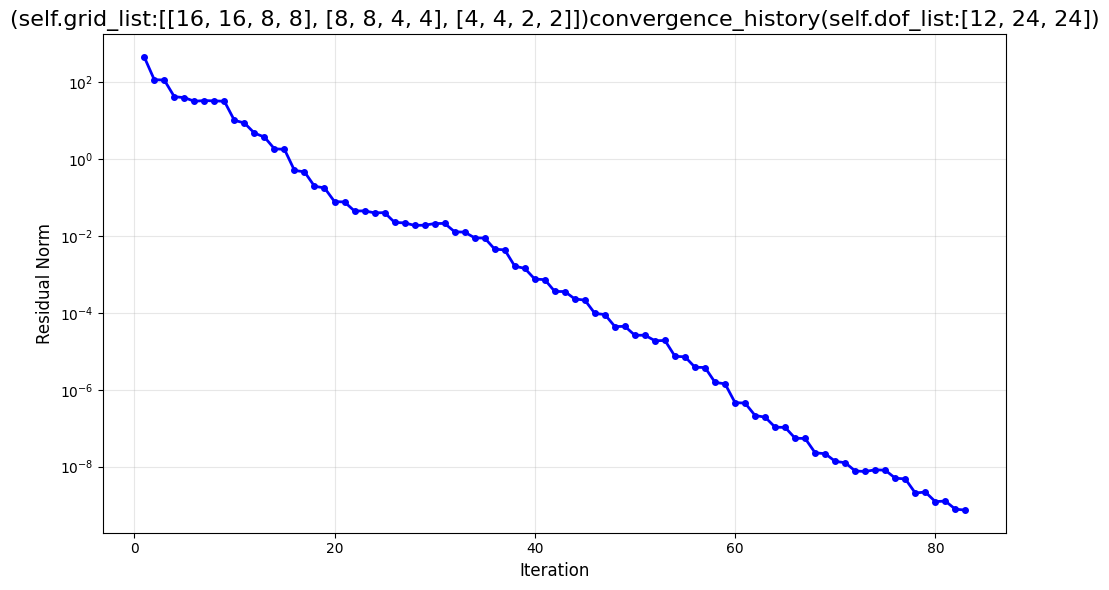

In [9]:
mg.num_levels = 3
x = mg.solve(b=b)
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-1.3138e-12-1.6315e-13j, -1.8152e-13-6.0174e-13j,
        -2.1635e-12-3.7090e-13j, -2.5550e-12-3.5316e-13j,
        -1.5362e-12-7.4274e-13j, -3.7199e-12+1.4812e-12j,
        -1.6310e-12+1.1056e-12j, -2.1720e-12+4.1467e-13j,
        -7.0433e-13+1.7311e-13j,  3.0747e-13-2.0917e-13j,
         1.6163e-12+1.3453e-12j, -6.6774e-13+5.4151e-13j,
         3.2530e-13-8.0824e-14j, -1.1036e-13+1.8141e-13j,
        -1.4757e-12+5.3485e-13j, -2.5979e-13-2.0996e-13j,
        -1.8399e-12+1.6358e-13j, -2.0424e-12-1.0301e-12j,
        -1.9985e-12-1.2764e-12j, -1.3403e-12+7.4218e-13j,
        -1.7985e-12-1.1128e-12j, -8.0991e-13+1.5922e-12j,
        -2.5113e-12-3.0553e-13j, -1.2136e-12+5.5933e-13j,
        -2.1875e-12+8.8707e-14j, -4.3310e-13+3.8552e-13j,
         7.6494e-14+2.1749e-12j, -9.2881e-13+5.0315e-13j,
         6.8756e-13+1.0467e-12j, -1.4716e-13+8.4621e-13j,
        -1.4072e-13+8.7125e-13j, -2.0333e-12-3.8858e-13j,
        -3.1184e-12+4.9299e-13j, -2.2627e-12-7.6028e-13j,
        -3.426

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

9.33767673626863e-11


In [13]:
mg.num_levels

3

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0068+0.0016j, 0.0089+0.0038j, 0.0076+0.0058j, 0.0098+0.0093j,
        0.0137+0.0036j, 0.0115+0.0033j, 0.0110+0.0004j, 0.0122+0.0022j,
        0.0132-0.0011j, 0.0102-0.0002j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0075-1.1641e-03j, 0.0090-9.9649e-04j, 0.0079-6.9606e-04j,
        0.0102-8.1503e-04j, 0.0087+7.2852e-04j, 0.0115-4.4556e-04j,
        0.0084+8.6115e-04j, 0.0107+4.1657e-04j, 0.0094+1.1728e-03j,
        0.0093-7.2453e-05j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0017-0.0282j,  0.0074-0.0254j,  0.0080-0.0240j,  0.0129-0.0301j,
         0.0176-0.0185j,  0.0214-0.0164j,  0.0283-0.0078j,  0.0432-0.0037j,
         0.0435+0.0046j,  0.0334+0.0195j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0036-8.7809e-03j,  0.0022-4.5107e-0

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0022+0.0046j, -0.0020+0.0059j, -0.0027+0.0066j, -0.0026+0.0059j,
        -0.0023+0.0060j, -0.0019+0.0049j, -0.0014+0.0054j, -0.0017+0.0045j,
        -0.0026+0.0037j, -0.0021+0.0056j, -0.0023+0.0054j, -0.0021+0.0053j,
        -0.0018+0.0058j, -0.0020+0.0059j, -0.0019+0.0060j, -0.0008+0.0030j,
        -0.0027+0.0027j, -0.0027+0.0039j, -0.0025+0.0046j, -0.0012+0.0055j,
        -0.0020+0.0047j, -0.0019+0.0052j, -0.0031+0.0058j, -0.0025+0.0041j,
        -0.0016+0.0043j, -0.0019+0.0039j, -0.0022+0.0039j, -0.0023+0.0049j,
        -0.0020+0.0053j, -0.0025+0.0057j, -0.0021+0.0039j, -0.0013+0.0042j,
        -0.0012+0.0034j, -0.0020+0.0048j, -0.0020+0.0061j, -0.0024+0.0046j,
        -0.0023+0.0039j, -0.0012+0.0034j, -0.0019+0.0032j, -0.0010+0.0039j,
        -0.0025+0.0046j, -0.0029+0.0045j, -0.0030+0.0063j, -0.0025+0.0059j,
        -0.0016+0.0046j, -0.0016+0.0035j, -0.0021+0.0047j, -0.0005+0.0040j,
        -0.0012+0.0039j, -0.0019+0.0056j, -0.0019+0.0049j, -0.0028+0.0046j,
        -0.0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(496.5132, device='cuda:0', dtype=torch.float64)
tensor([-0.0469+0.4423j, -0.8774-0.8647j, -0.2386-0.5692j,  0.5377-0.2412j,
        -0.8969+0.4641j,  0.1649+0.1392j, -0.0179+0.4582j,  0.2928-1.6413j,
         0.8080+0.1465j, -0.1400+0.5804j, -0.6643-1.1795j,  0.5160-0.4944j,
        -0.6510+0.6158j,  1.2843-0.4617j,  0.7610+1.6788j, -0.3145+0.5608j,
        -0.1702-0.0568j,  0.7620+1.2433j, -0.3826-1.0069j,  1.2509+1.0302j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:496.5132002628361
Norm of r:703.0009069761002
Norm of x0:443.7193747128637
BICGSTAB-Iteration 0: Residual = 1.211278e+02, Time = 0.011976 s
BICGSTAB-Iteration 1: Residual = 3.995655e+01, Time = 0.011956 s
BICGSTAB-Iteration 2: Residual = 7.858867e+01, Time = 0.011975 s
BICGSTAB-Iteration 3: Residual = 1.337958e+01, Time = 0.012146 s
BICGSTAB-Iteration 4: Residual = 1.050225e+01, Time = 0.012018 s
BICGSTAB-Iteration 5: Residual = 5.721529e+00, Time = 0.012897 s
BICGSTAB-Iteration 6: Residual = 4.379509

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:443.6490785219461
Norm of r:665.9144968759487
Norm of x0:443.74610024546007
BICGSTAB-Iteration 0: Residual = 1.440566e+02, Time = 0.013128 s
BICGSTAB-Iteration 1: Residual = 6.186094e+01, Time = 0.013062 s
BICGSTAB-Iteration 2: Residual = 6.187640e+01, Time = 0.012901 s
BICGSTAB-Iteration 3: Residual = 4.133247e+01, Time = 0.012762 s
BICGSTAB-Iteration 4: Residual = 2.606749e+01, Time = 0.012758 s
BICGSTAB-Iteration 5: Residual = 1.929171e+01, Time = 0.012820 s
BICGSTAB-Iteration 6: Residual = 1.726186e+01, Time = 0.012868 s
BICGSTAB-Iteration 7: Residual = 1.398749e+01, Time = 0.013668 s
BICGSTAB-Iteration 8: Residual = 1.527878e+01, Time = 0.013143 s
BICGSTAB-Iteration 9: Residual = 9.359256e+00, Time = 0.012902 s
BICGSTAB-Iteration 10: Residual = 8.586793e+00, Time = 0.012707 s
BICGSTAB-Iteration 11: Residual = 7.707306e+00, Time = 0.012749 s
BICGSTAB-Iteration 12: Residual = 7.429375e+00, Time = 0.013282 s
BICGSTAB-Iteration 13: Residual = 7.149076e+00, Time = 0.012949 s


In [18]:
_null_vec.flatten()[:100]

tensor([0.0017+0.0017j, 0.0014+0.0018j, 0.0013+0.0018j, 0.0014+0.0022j,
        0.0014+0.0020j, 0.0015+0.0019j, 0.0017+0.0016j, 0.0016+0.0019j,
        0.0015+0.0019j, 0.0011+0.0017j, 0.0015+0.0018j, 0.0013+0.0022j,
        0.0013+0.0019j, 0.0017+0.0018j, 0.0017+0.0017j, 0.0016+0.0018j,
        0.0012+0.0023j, 0.0011+0.0024j, 0.0009+0.0021j, 0.0012+0.0021j,
        0.0014+0.0018j, 0.0013+0.0019j, 0.0013+0.0017j, 0.0011+0.0016j,
        0.0015+0.0016j, 0.0012+0.0016j, 0.0017+0.0018j, 0.0015+0.0016j,
        0.0013+0.0019j, 0.0013+0.0021j, 0.0012+0.0021j, 0.0011+0.0022j,
        0.0012+0.0023j, 0.0010+0.0022j, 0.0015+0.0023j, 0.0012+0.0022j,
        0.0011+0.0019j, 0.0012+0.0018j, 0.0011+0.0019j, 0.0008+0.0018j,
        0.0013+0.0016j, 0.0014+0.0018j, 0.0014+0.0017j, 0.0015+0.0016j,
        0.0015+0.0021j, 0.0015+0.0021j, 0.0011+0.0022j, 0.0011+0.0021j,
        0.0013+0.0021j, 0.0010+0.0017j, 0.0009+0.0024j, 0.0009+0.0019j,
        0.0011+0.0019j, 0.0011+0.0018j, 0.0011+0.0013j, 0.0012+0